# Convolutional autoencoding and clustering for automatic puzzeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import sys
import os
import cv2
import tensorflow as tf
from tensorflow import keras

## Load and Preprocess Data

Size of dataset: 100
Size of image: (453, 422, 4)
Type: <class 'numpy.ndarray'>


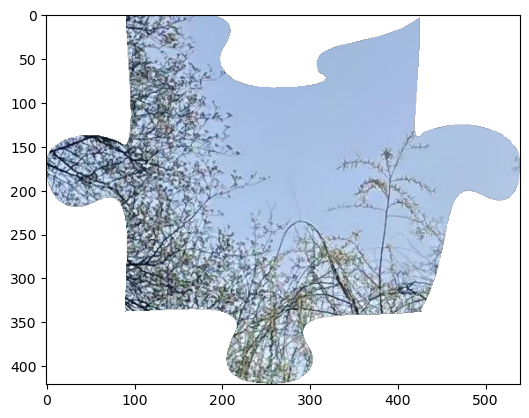

In [2]:
images = [plt.imread(os.path.join('data', 'size-100', 'raster', str(file_num)+'.png')) for file_num in range(100)]

num_images = len(images)
print('Size of dataset: '+ str(num_images))
print('Size of image: '+ str(images[7].shape))
print('Type: '+str(type(images[1])))
plt.imshow(images[79])

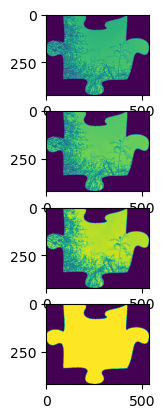

In [3]:
img = images[79]
fig, axs = plt.subplots(4)
for layer in range(0,4):
    axs[layer].imshow(img[:,:,layer])




### Extract shape of the piece and add padding

In [4]:
# Here we get the max length and width for later padding
width_array = [images[i].shape[0] for i in range(num_images)]
length_array = [images[i].shape[1] for i in range(num_images)]
#maxw = np.max(width_array)
#maxl = np.max(length_array)

maxw = 576
maxl = 576
print('max width: '+ str(maxw) + ", max length: " + str(maxl))

# The last layer is the transparency layer, which is basically the shape of the piece
images_bw = [image[:,:,3] for image in images] 

# Here comes the padding
images_p = []
for image in images_bw: 
    # image = images_bw[5]
    w,l = image.shape
    width_ext = int((maxw - w)/2)
    length_ext = int((maxl - l)/2)
    
    #Blocks of zeros to complete the padding
    zero_block_w = np.zeros([width_ext, l]) 
    zero_block_l = np.zeros([maxw,length_ext])

    if w+2*width_ext == maxw: # This is to be sure that all images are going to have the same dimentions
        image_p = np.concatenate((zero_block_w,image,zero_block_w),axis=0) 
    else:
        extraline_w = np.zeros([1,l]) # This extra lines are to complete the dimensions if necessary
        image_p = np.concatenate((zero_block_w,image,zero_block_w,extraline_w),axis=0)

    if l+2*length_ext == maxl:
        image_p = np.concatenate((zero_block_l,image_p,zero_block_l),axis=1)
    else:
        extraline_l = np.zeros([maxw,1])
        image_p = np.concatenate((zero_block_l,image_p,zero_block_l,extraline_l),axis=1)

    # print(image_p.shape)
    # We save the negative of the image on the list
    
    #images_p.append(np.abs(-(image_p-1)))
    images_p.append(image_p)


max width: 576, max length: 576


<class 'numpy.ndarray'>
(576, 576)
1.0
0.0


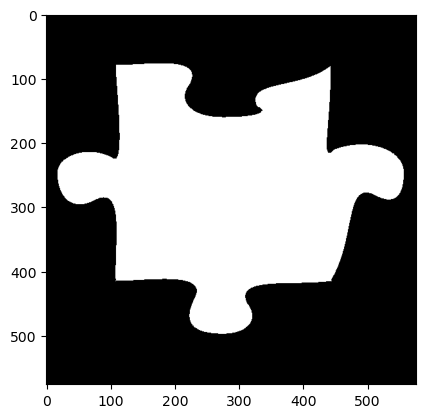

In [5]:
image_bw = images_p[79]
plt.imshow(image_bw,cmap = 'gray')
# plt.imshow(image_bw,cmap = 'Greys')

print(type(image_bw))
print(image_bw.shape)
print(np.max(image_bw))
print(np.min(image_bw))


### Resize Image

In [6]:
# If you want a 64x64 image, size = stride = 9
size = 9
stride = 9
images_rs = []
shape_new_image = (int(image_p.shape[0]/size),int(image_p.shape[0]/size))
row_size = 64
col_size = 64

for image_p in images_p: 
    image_rs = np.zeros(shape_new_image)
    i_rs = 0
    j_rs = 0
    for i in range(0,image_p.shape[0]-int(size/2),stride):
        for j in range(0,image_p.shape[1]-int(size/2),stride):
            window = image_p[i:i+size,j:j+size].flatten()
            #image_rs[i_rs][j_rs] = np.max(window) # choose how to reduce the size of the image
            image_rs[i_rs][j_rs] = np.mean(window) # choose how to reduce the size of the image
            #image_rs[i_rs][j_rs] = window[0] # choose how to reduce the size of the image
            j_rs += 1
        i_rs += 1
        j_rs = 0
    dim = (col_size,row_size)
    #image_rs = cv2.resize(image,dim,interpolation = cv2.INTER_AREA)
    images_rs.append(image_rs)
    
#plt.imshow(image_rs,cmap = 'Greys')

<class 'numpy.ndarray'>
(64, 64)
1.0
0.0


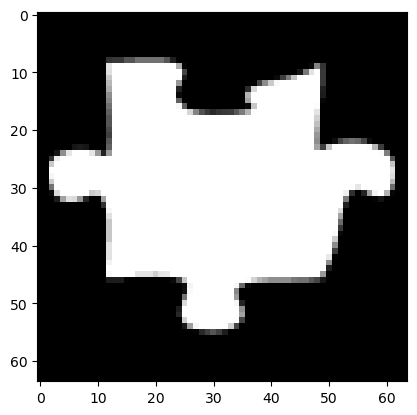

In [7]:
image_rs = images_rs[79]
plt.imshow(image_rs,cmap = 'gray')
print(type(image_rs))
print(image_rs.shape)
print(np.max(image_rs))
print(np.min(image_rs))

## Encode Image Data
### Convolutional Autoencoder

In [8]:
from keras.layers import Conv2D
from keras.layers import Input

from keras.layers import MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Model

from sklearn.model_selection import train_test_split

In [9]:
X = np.array(images_rs)
y = X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:

input_img = Input(shape=(64, 64, 1))

# Encoder
enc_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
enc_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(enc_pool1)
enc_pool2 = MaxPooling2D((2, 2), padding='same')(enc_conv2)
enc_conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(enc_pool2)
enc_pool2 = MaxPooling2D((2, 2), padding='same')(enc_conv3)
enc_flat = Flatten()(enc_pool2) # Added this layer to flatten
enc_output = Dense(64)(enc_flat) # Fully connected layer, encoded output

#decoder
dec_FC = Dense(2048)(enc_output) # Fully conected layer
dec_reshape = Reshape((8,8,32))(dec_FC) # reshape to fit the shape of next layer
dec_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(dec_reshape)
dec_upsample1 = UpSampling2D((2, 2))(dec_conv1)
dec_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_upsample1)
dec_upsample2 = UpSampling2D((2, 2))(dec_conv2)
dec_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(dec_upsample2)
dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)



#dec_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_ouput)
#dec_upsample1 = UpSampling2D((2, 2))(dec_conv2)
#dec_conv3 = Conv2D(8, (3, 3), activation='relu')(dec_upsample2)
#dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
#dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)


autoencoder = Model(input_img, dec_output)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') 

 

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640  

In [14]:
# Train the network
autoencoder.fit(X_train, X_train, epochs=100, batch_size=100, shuffle=True,validation_data=(X_test, X_test))

Epoch 1/100
1/1 [==============================] - 0s 486ms/step - loss: 0.0744 - val_loss: 0.1099
Epoch 2/100
1/1 [==============================] - 0s 314ms/step - loss: 0.0734 - val_loss: 0.1091
Epoch 3/100
1/1 [==============================] - 0s 314ms/step - loss: 0.0726 - val_loss: 0.1089
Epoch 4/100
1/1 [==============================] - 0s 267ms/step - loss: 0.0719 - val_loss: 0.1085
Epoch 5/100
1/1 [==============================] - 0s 330ms/step - loss: 0.0712 - val_loss: 0.1083
Epoch 6/100
1/1 [==============================] - 0s 299ms/step - loss: 0.0707 - val_loss: 0.1095
Epoch 7/100
1/1 [==============================] - 0s 371ms/step - loss: 0.0707 - val_loss: 0.1090
Epoch 8/100
1/1 [==============================] - 0s 266ms/step - loss: 0.0718 - val_loss: 0.1178
Epoch 9/100
1/1 [==============================] - 0s 267ms/step - loss: 0.0763 - val_loss: 0.1160
Epoch 10/100
1/1 [==============================] - 0s 251ms/step - loss: 0.0792 - val_loss: 0.1135
Epoch 11/

1/1 [==============================] - 0s 267ms/step - loss: 0.0477 - val_loss: 0.1124
Epoch 84/100
1/1 [==============================] - 0s 252ms/step - loss: 0.0479 - val_loss: 0.1122
Epoch 85/100
1/1 [==============================] - 0s 251ms/step - loss: 0.0474 - val_loss: 0.1130
Epoch 86/100
1/1 [==============================] - 0s 188ms/step - loss: 0.0472 - val_loss: 0.1128
Epoch 87/100
1/1 [==============================] - 0s 219ms/step - loss: 0.0472 - val_loss: 0.1127
Epoch 88/100
1/1 [==============================] - 0s 268ms/step - loss: 0.0468 - val_loss: 0.1142
Epoch 89/100
1/1 [==============================] - 0s 235ms/step - loss: 0.0468 - val_loss: 0.1129
Epoch 90/100
1/1 [==============================] - 0s 236ms/step - loss: 0.0467 - val_loss: 0.1139
Epoch 91/100
1/1 [==============================] - 0s 235ms/step - loss: 0.0464 - val_loss: 0.1143
Epoch 92/100
1/1 [==============================] - 0s 218ms/step - loss: 0.0466 - val_loss: 0.1147
Epoch 93/100


1/1 [==============================] - 0s 47ms/step


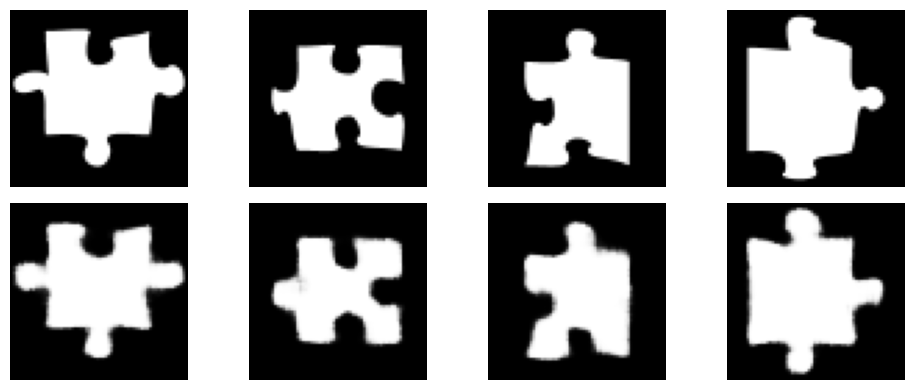

In [15]:
reconstructed_images = autoencoder.predict(X_test) # reconstruct images from X_test

image_shape = (64, 64, 1)

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
for i in range(4):
    axes[0, i].imshow(X_test[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [16]:
encoder = Model(input_img, enc_output)
encoded_imgs = encoder.predict(X)
encoded_imgs.shape

4/4 [==============================] - 0s 26ms/step


(100, 64)

In [17]:
reconstructed_images = autoencoder.predict(X).reshape(100,64,64) # Check dimensions
mse = tf.keras.losses.MeanSquaredError()
mse_autoencoder = mse(X, reconstructed_images).numpy() 
# reconstructibilty = 1 - mse_autoencoder
compression_rate =1 - 64/(64*64)
print("MSE: " + str(mse_autoencoder))
#print("Reconstructibility: " + str(reconstructibilty))
print("Compression rate: " + str(compression_rate))

4/4 [==============================] - 0s 37ms/step
MSE: 0.008776557
Compression rate: 0.984375


### Principal Component Analysis

In [18]:
from sklearn.decomposition import PCA

In [19]:
#
X_flat = np.reshape(X,(100,-1))
print(X_flat.shape)
num_components = 100 # reconstruct with all of the components
# Create a PCA object and specify the number of components you want to keep
pca = PCA(n_components=num_components)
#pca = PCA(n_components=17)

# Fit the PCA model to the data
pca.fit(X_flat)

# Transform the data to the lower-dimensional space
X_pca = pca.transform(X_flat)
print(X_pca.shape)

(100, 4096)
(100, 100)


In [20]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("90% of cumulative variance is explained by:", np.where(cumulative_variance >= 0.9)[0][0],'principal components')

90% of cumulative variance is explained by: 35 principal components


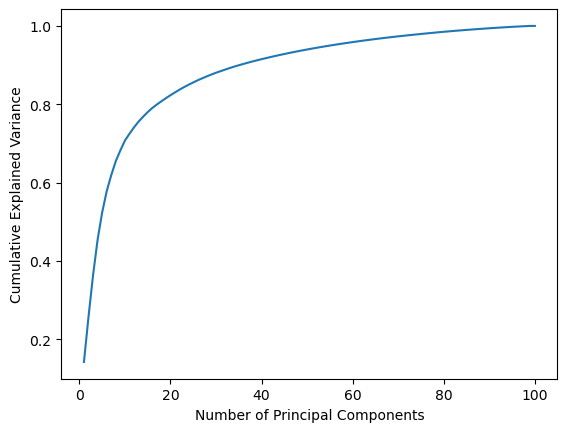

In [21]:
image_shape = (64, 64, 1)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Plot the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [22]:
# Extract num_reconstructed_components
num_reconstructed_components = 64
pca_rec = PCA(n_components=num_reconstructed_components)
pca_rec.fit(X_flat)
X_pca = pca_rec.transform(X_flat)

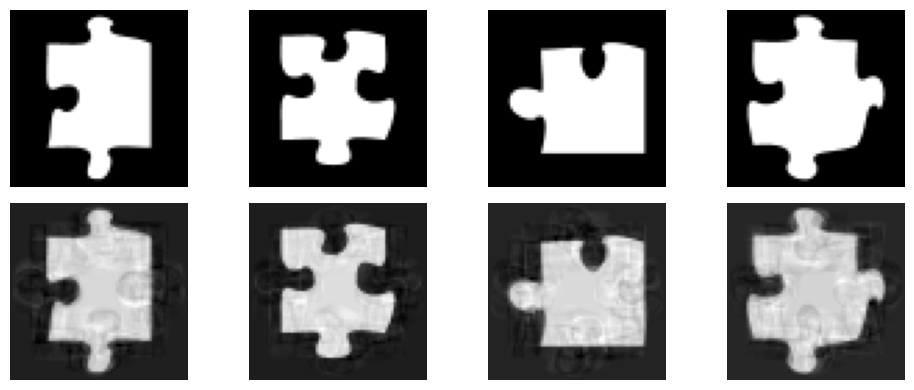

In [23]:
# Reconstruct a subset of principal components to visualize the reconstructed images
reconstructed_images = pca_rec.inverse_transform(X_pca)

# Reshape the reconstructed images back to their original shape
reconstructed_images = np.reshape(reconstructed_images, (num_images, *image_shape))

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
for i in range(4):
    axes[0, i].imshow(X[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [24]:
#pca.score_samples(X)
#pca.components_.shape
print(np.sum(pca.singular_values_))
#np.linalg.eigvals(pca)
#pca.components_
print(np.sum(pca_rec.singular_values_))
reconstructability =np.sum(pca.singular_values_)/np.sum(pca_rec.singular_values_)
print("Reconstructability: "+str(reconstructability))
print("Compression: "+str(64/(64*64)))


1365.3120960657793
1155.3927463167076
Reconstructability: 1.1816865740401057
Compression: 0.015625


### Investigate the encoding approaches

In [25]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [26]:
def print_pieces(images,labels):
    k = len(np.unique(labels))
    # print(k)
    num_columns = 15
    fig, axes = plt.subplots(nrows=k,ncols=num_columns)
    for i in range(k):
        for j in range(num_columns):
            axes[i,j].axis('off')  
    #plt.axis('off')
    #count = np.zeros()
    acum = 0
    for l in range(k):
        num_images = np.count_nonzero(labels == l)
        #print(num_images)
        acum = acum + num_images
        count = 0
        #img_label = images[labels == l]
        img_label = np.nonzero(labels == l)[0]
        for i in img_label:
            #axes.imshow(image, cmap='gray')
            axes[l,count].imshow(images[i], cmap='gray')
            #axes[l,count].axis('off')            
            count +=1
    print(acum)

## Clustering
### K-means

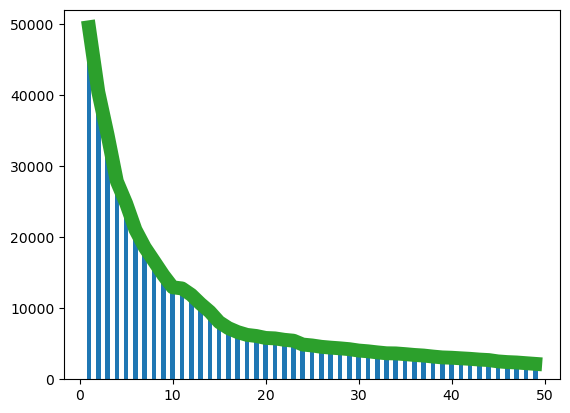

In [27]:
## K-means clustering with Autoencoder
#X_clust = X.reshape(X.shape[0], -1)
X_clust = encoded_imgs
#X_clust = X_pca

# Apply k-means clustering
costs = []
for i in range(1,50):    
    kmeans = KMeans(n_clusters=i, random_state=42,n_init = 'auto')
    kmeans.fit(X_clust)
    costs.append(kmeans.inertia_)
    
plt.bar(np.arange(1, len(costs) + 1), np.array(costs), width = 0.5)
ax = plt.gca()
ax.plot(np.arange(1, len(costs) + 1), np.array(costs), lw = 10, c = 'C2')

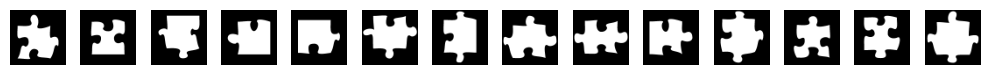

In [28]:
# From plot we found out that 20 is the optimal number of clusters
k = 14

kmeans = KMeans(n_clusters=k, random_state=42,n_init = 'auto')
kmeans.fit(X_clust)
labels_km = kmeans.labels_

# Visualize the clustering result
fig, axes = plt.subplots(1, k, figsize=(10, 2))
for i in range(k):
    cluster_images = X[labels_km == i]
    axes[i].imshow(cluster_images[0], cmap='gray')
    #axes[i].set_title(f'Cluster {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

100


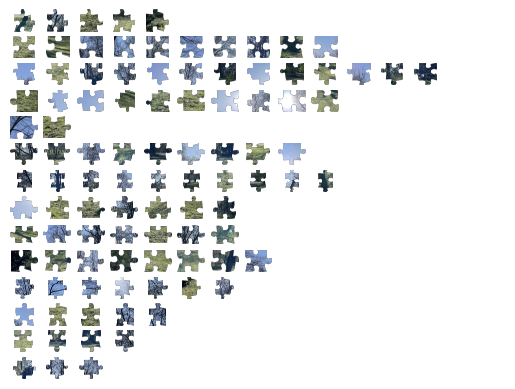

In [29]:
print_pieces(images,labels_km)

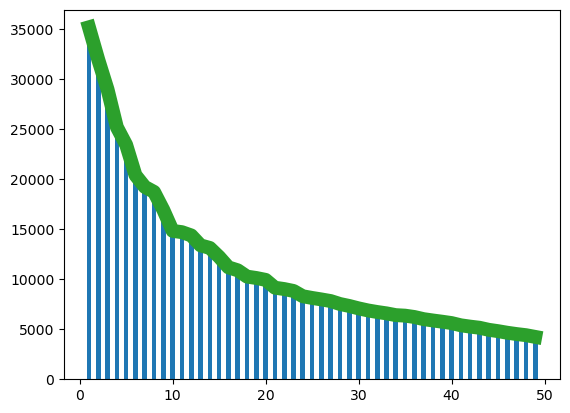

In [30]:
# K-means clustering with PCA
#X_clust = X.reshape(X.shape[0], -1)
#X_clust = encoded_imgs
X_clust = X_pca

# Apply k-means clustering
# k = 5  # Specify the number of clusters
costs = []
for i in range(1,50):    
    kmeans = KMeans(n_clusters=i, random_state=42,n_init = 'auto')
    kmeans.fit(X_clust)
    costs.append(kmeans.inertia_)
    
plt.bar(np.arange(1, len(costs) + 1), np.array(costs), width = 0.5)
ax = plt.gca()
ax.plot(np.arange(1, len(costs) + 1), np.array(costs), lw = 10, c = 'C2')

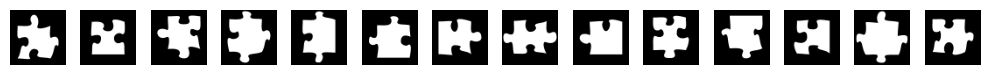

In [31]:
# From plot we found out that 20 is the optimal number of clusters
k = 14

kmeans = KMeans(n_clusters=k, random_state=42,n_init = 'auto')
kmeans.fit(X_clust)
labels_km = kmeans.labels_

# Visualize the clustering result
fig, axes = plt.subplots(1, k, figsize=(10, 2))
for i in range(k):
    cluster_images = X[labels_km == i]
    axes[i].imshow(cluster_images[0], cmap='gray')
    #axes[i].set_title(f'Cluster {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

100


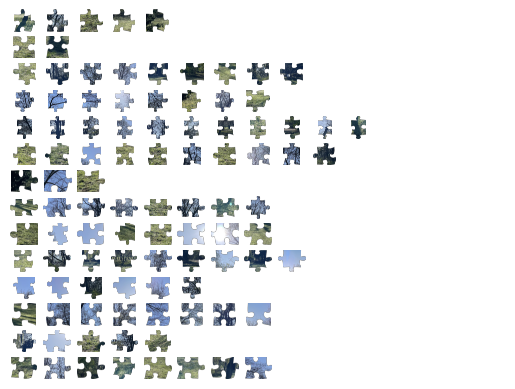

In [32]:
print_pieces(images,labels_km)

### DBSCAN

In [42]:
from sklearn.neighbors import NearestNeighbors

# Encode the images
# encoded_imgs = encoder.predict(X)

# Apply Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=8)
neighbors.fit(encoded_imgs)

# Find the nearest neighbors for a specific point
#query_point = ...  # Specify the query point in the encoded feature space
distances, indices = neighbors.kneighbors(encoded_imgs)


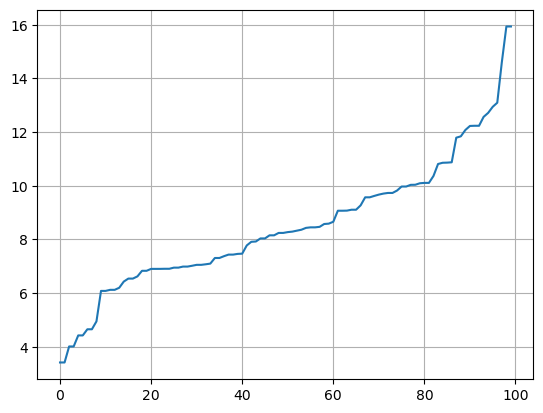

In [43]:
distances = np.sort(distances, axis=0)
distances_1 = distances[:,1]
plt.grid(True)
plt.plot(distances_1)

In [44]:
from sklearn.cluster import DBSCAN

In [ ]:
for epsilon in range(12,15):
    dbscan = DBSCAN(eps = epsilon,min_samples=2) # eps between 12 and 14
    labels_dbscan = dbscan.fit_predict(encoded_imgs)
    print("For eps ="+str(epsilon))
    print("First row are noise results")
    print_pieces(images,labels_dbscan+1)

For eps =12
First row are noise results


## Additional Task: Fully Automated Puzzeling Algorithm

In [ ]:
## CELL HERE JUST IN CASE SOMETHING GOES WRONG WITH FUNCTION IMPLEMENTATION ABOVE

#num_images = np.count_nonzero(labels == l) # number of pieces with that label

#fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize = (6, 4))
 #Variable to keep the count of images

num_columns = 15
fig, axes = plt.subplots(nrows=k,ncols=num_columns)
for i in range(k):
    for j in range(num_columns):
        axes[i,j].axis('off')  
#plt.axis('off')
#count = np.zeros()
acum = 0
for l in range(k):
    num_images = np.count_nonzero(labels == l)
    #print(num_images)
    acum = acum + num_images
    count = 0
    #img_label = images[labels == l]
    img_label = np.nonzero(labels == l)[0]
    for i in img_label:
        #axes.imshow(image, cmap='gray')
        axes[l,count].imshow(images[i], cmap='gray')
        #axes[l,count].axis('off')            
        count +=1
print(acum)